In [1]:
from __future__ import print_function, division, absolute_import
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import numpy as np
# from scipy.fft import irfft,rfft,rfftn,irfftn,fftn,ifftn,fft,ifft,fft2,rfft2
import itertools
from math import pi
# from orbithunter.glue import *
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft
from functools import lru_cache
from orbithunter.arrayops import swap_modes
from scipy.sparse.linalg import lsqr, lsmr, LinearOperator
from scipy.optimize import newton_krylov, root, minimize
%matplotlib inline
import time
import pandas as pd

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


scipy.optimize.newton_krylov has the following inner methods (outer is newton, of course)
‘lgmres’, ‘gmres’, ‘bicgstab’, ‘cgs’, ‘minres’

This is not solving a linear system so it doesn't matter what dimensions are, I think. 

and for least squares
'lsqr', 'lsmr'

And so, focus on implementing lsqr, lsmr

then newton_krylov, 

then root. 

FOR LSQR&LSMR:
using linear operator because of memory. 

May be useful to build-in the preconditioning as opposed to applying it a posteriori

If krylov runs well, then test the performance of its inner-loop methods.

In [2]:
def _scipy_sparse_linalg_solver_wrapper(orbit_, damp=1.0, atol=1e-06, btol=1e-06,
                                        method='lsqr', maxiter=None, conlim=1e+08,
                                        show=False, calc_var=False, **orbithunter_kwargs):

    linear_operator_shape = (orbit_.state.size, orbit_.state_vector().size)
    istop = 1
    exit_code = 0
    itn = 0
    outer_itn = 0
    # Return codes that represent good results from the SciPy least-squares solvers.
    good_codes = [0, 1, 2, 4, 5]
    residual = orbit_.residual()

    outer_tol = orbithunter_kwargs.get('outer_tol', 1e-6)
    outer_maxiter = orbithunter_kwargs.get('outer_maxiter', 16*orbit_.N*orbit_.M)
    max_damp_factor = orbithunter_kwargs.get('outer_damp_max', 8)

    while (residual > outer_tol) and (istop in good_codes) and outer_itn < outer_maxiter:
        outer_itn += 1
        # The operator depends on the current state; A=A(orbit)
        def rmv_func(v):
            # _process_newton_step turns state vector into class object.
            v_orbit = orbit_.from_numpy_array(v, **orbithunter_kwargs)
            v_orbit.T, v_orbit.L, v_orbit.S = orbit_.T, orbit_.L, orbit_.S
            rmatvec_result = orbit_.rmatvec(v_orbit, **orbithunter_kwargs).state_vector().reshape(-1, 1)
            return rmatvec_result

        def mv_func(v):
            # _state_vector_to_orbit turns state vector into class object.
            v_orbit = orbit_.from_numpy_array(v, **orbithunter_kwargs)
            v_orbit.T, v_orbit.L, v_orbit.S = orbit_.T, orbit_.L, orbit_.S
            return orbit_.matvec(v_orbit, **orbithunter_kwargs).state.reshape(-1, 1)

        orbit_linear_operator = LinearOperator(linear_operator_shape, mv_func, rmatvec=rmv_func, dtype=float)
        b = -1.0 * orbit_.spatiotemporal_mapping(**orbithunter_kwargs).state.reshape(-1, 1)
        damp_factor = 0

        if method == 'lsmr':
            result_tuple = lsmr(orbit_linear_operator, b, damp=damp, atol=atol, btol=btol,
                                conlim=conlim, maxiter=maxiter, show=show)
        elif method == 'lsqr':
            # Depends heavily on scaling of the problem.
            result_tuple = lsqr(orbit_linear_operator, b, damp=damp, atol=atol, btol=btol, conlim=conlim,
                                iter_lim=maxiter, show=show, calc_var=calc_var)
        else:
            raise ValueError('Unknown solver %s' % method)

        x = result_tuple[0]
        istop = result_tuple[1]
        itn += result_tuple[2]

        dorbit = orbit_.from_numpy_array(x, **orbithunter_kwargs)
        next_orbit = orbit_.increment(dorbit)
        next_residual = next_orbit.residual()
        while next_residual > residual:
            damp_factor += 1
            next_orbit = orbit_.increment(dorbit, stepsize=2 ** -damp_factor)
            next_residual = next_orbit.residual()
            if damp_factor > max_damp_factor:
                return orbit_, itn, istop
        else:
            orbit_ = next_orbit
            residual = next_residual
            if orbithunter_kwargs.get('verbose', False):
                if not (np.mod(outer_itn,(outer_maxiter // 10))):
                    print('#', end='')
    exit_code = 1
    return orbit_, itn, istop


def _scipy_optimize_minimize_wrapper(orbit_, method=None, bounds=None,
                                     tol=None, callback=None, options=None, **kwargs):

    if method in ['newton-cg', 'tnc']:
        # This is a work-around to have different defaults for the different methods.
        preconditioning = kwargs.get('preconditioning', False)
    else:
        preconditioning= kwargs.get('preconditioning', True)

    def _cost_function_scipy_minimize(x):
        '''
        :param x0: (n,) numpy array
        :param args: time discretization, space discretization, subClass from orbit.py
        :return: value of cost functions (0.5 * L_2 norm of spatiotemporal mapping squared)
        '''

        '''
        Note that passing Class as a function avoids dangerous statements using eval()
        '''
        x_orbit = orbit_.from_numpy_array(x, **kwargs)
        return x_orbit.residual()

    def _cost_function_jac_scipy_minimize(x):
        """ The jacobian of the cost function (scalar) can be expressed as a vector product

        Parameters
        ----------
        x
        args

        Returns
        -------

        Notes
        -----
        The gradient of 1/2 F^2 = J^T F, rmatvec is a function which does this matrix vector product
        Will always use preconditioned version by default, not sure if wise.
        """
        x_orbit = orbit_.from_numpy_array(x)
        return x_orbit.rmatvec(x_orbit.spatiotemporal_mapping(), preconditioning=preconditioning).state_vector().ravel()

    if method in ['newton-cg', 'tnc'] and kwargs.get('jacobian_on', True):
        # This is a work-around to have different defaults for the different methods.
        jac_ = _cost_function_jac_scipy_minimize
    elif method in ['cg', 'l-bfgs-b'] and kwargs.get('jacobian_on', True):
        # This is a work-around to have different defaults for the different methods.
        jac_ = _cost_function_jac_scipy_minimize
    else:
        jac_ = None

    result = minimize(_cost_function_scipy_minimize, orbit_.state_vector(),
                      method=method, jac=jac_, bounds=bounds, tol=tol,
                      callback=callback, options=options)
    result_orbit = orbit_.from_numpy_array(result.x)
    return result_orbit, result.nit, result.success



def _scipy_optimize_root_wrapper(orbit_, method=None, tol=None, callback=None, options=None, **orbithunter_kwargs):
    # I really don't like this workaround but scipy.optimize.root can't handle unexpected arguments.
    parameter_constraints = orbithunter_kwargs.get('parameter_constraints', (False, False, False))
    preconditioning = orbithunter_kwargs.get('preconditioning', False)
    # define the functions using orbit instance within scope instead of passing orbit
    # instance as arg to scipy functions.

    def _cost_function_scipy_root(x):
        '''
        :param x0: (n,) numpy array
        :param args: time discretization, space discretization, subClass from orbit.py
        :return: value of cost functions (0.5 * L_2 norm of spatiotemporal mapping squared)
        '''

        '''
        Note that passing Class as a function avoids dangerous statements using eval()
        '''
        x_orbit = orbit_.from_numpy_array(x, **orbithunter_kwargs)
        n_params = x_orbit.state_vector().size - x_orbit.state.size
        # Root requires input shape = output shape.
        return np.concatenate((x_orbit.spatiotemporal_mapping(**orbithunter_kwargs).state.ravel(),
                               np.zeros(n_params)), axis=0)

    def _cost_function_jac_scipy_root(x):
        """ The jacobian of the cost function (scalar) can be expressed as a vector product

        Parameters
        ----------
        x
        args

        Returns
        -------

        Notes
        -----
        The gradient of 1/2 F^2 = J^T F, rmatvec is a function which does this matrix vector product
        Will always use preconditioned version by default, not sure if wise.
        """

        x_orbit = orbit_.from_numpy_array(x, **orbithunter_kwargs)
        n_params = x_orbit.state_vector().size - x_orbit.state.size
        return np.concatenate((x_orbit.jacobian(**orbithunter_kwargs),
                               np.zeros([n_params, x_orbit.state_vector().size])), axis=0)
    # If not providing jacobian numerical approximation is used which can be beneficial.
    if method == 'lm' and orbithunter_kwargs.get('jacobian_on', True):
        jac_ = _cost_function_jac_scipy_root
        
    elif method in ['lgmres', 'gmres', 'bicgstab', 'cgs', 'minres']:
        # These methods are actually inner loop methods of 'krylov' method; need to be passed into options dict.
        if options is None:
            options = {'jac_options': {'method': method}}
        elif isinstance(options, dict):
            options['jac_options'] = {'method': method}
        method = 'krylov'
        jac_ = None
    else:
        jac_ = None
    result = root(_cost_function_scipy_root, orbit_.state_vector(),
                  method=method, jac=jac_, tol=tol,
                  callback=callback, options=options)
    result_orbit = orbit_.from_numpy_array(result.x, **orbithunter_kwargs)
    return result_orbit, 0, result.success

In [3]:
test = read_h5('OrbitKS_L37p297_T79p778.h5', directory='local')
orbit_ = rediscretize(test, new_N=64, new_M=32)
np.random.seed(0)
orbit_ = orbit_ + OrbitKS(state=0.1*np.random.randn(*orbit_.state.shape), state_type='field')
orbit_ = orbit_.convert(to='modes')
cdict = {1:'success', 0:'failure', 2:'success'}
orbit_list = []
res, tim = [], []
max_iter = 3

In [4]:
methods = (['cg', 'newton-cg', 'l-bfgs-b', 'tnc']
           +['lgmres', 'gmres', 'bicgstab', 'cgs', 'minres']
           +['lsqr','lsmr']+['adj', 'lstsq'])

In [5]:
def method_efficiency(orbit_instance, method, maxiter, **kwargs):
    preconditioning = kwargs.get('preconditioning', False)
    print(method)
    print('\n')
    t0 = time.time()
    if method in ['cg', 'newton-cg', 'l-bfgs-b', 'tnc']:
        result_orbit, nit, success = _scipy_optimize_minimize_wrapper(orbit_, method=m,
                                                                      options={'maxiter':maxiter},
                                                                      preconditioning=preconditioning)
    elif method in ['lgmres', 'gmres', 'bicgstab', 'cgs', 'minres']:
        result_orbit, nit, success = _scipy_optimize_root_wrapper(orbit_, method=m,
                                                                      options={'maxiter':maxiter},
                                                                      preconditioning=preconditioning)
    elif method in ['lsqr','lsmr']:
        result_orbit, nit, success = _scipy_sparse_linalg_solver_wrapper(orbit_, method=m,
                                                                      outer_maxiter=10,
                                                                      preconditioning=preconditioning)
    elif method in ['adj', 'lstsq']:
        result = converge(orbit_, method=m, maxiter=10, preconditioning=preconditioning)
        result_orbit = result.orbit
    else: 
        return 0, 0, 0, 0, 0
    
    t1 = time.time()
    print('\n')
    print('time', t1-t0, 'residual', result_orbit.residual(), '\n')
    print('########################################################')
    res = result_orbit.residual()
    tim = t1-t0
    # define as percentage reduction per second. 
    efficiency = (1 - (res/orbit_instance.residual())) / tim
    efficiency_log10 = np.log10(efficiency+1)
    return res, tim, efficiency, efficiency_log10, preconditioning

In [6]:
maxiter = 10
res_list, time_list, efficiency_list, efficiency_log10_list, preconditioning_list = [], [], [], [], []
for m in methods:
    res, tim, efficiency, efficiency_log10, preconditioning = method_efficiency(orbit_, m, maxiter, preconditioning=False)
    res_list.append(res)
    time_list.append(tim)
    efficiency_list.append(efficiency)
    efficiency_log10_list.append(efficiency_log10)
    preconditioning_list.append(preconditioning)

cg




time 0.0419611930847168 residual 10.894019685407466 

########################################################
newton-cg




time 0.6345868110656738 residual 0.01009428529365791 

########################################################
l-bfgs-b




time 0.05095267295837402 residual 11.825106769084528 

########################################################
tnc




time 0.02697467803955078 residual 69.10383159310902 

########################################################
lgmres




time 0.3026576042175293 residual 0.7782120931693863 

########################################################
gmres




time 0.13100886344909668 residual 0.841951176426087 

########################################################
bicgstab




C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\isolve\iterative.py:2: DeprecationWarning: scipy.sparse.linalg.bicgstab called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``bicgstab(..., atol=0)``, or to retain the old behavior ``bicgstab(..., atol='legacy')``
  




time 0.20998358726501465 residual 39.51590353470551 

########################################################
cgs




C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\isolve\iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cgs called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cgs(..., atol=0)``, or to retain the old behavior ``cgs(..., atol='legacy')``
  




time 0.2200334072113037 residual 83.66572770420831 

########################################################
minres




time 0.047026872634887695 residual 64.90533347676018 

########################################################
lsqr




time 5.753311634063721 residual 2.297405470991572 

########################################################
lsmr




time 2.250190496444702 residual 1.8285822023367815 

########################################################
adj




time 0.021080970764160156 residual 25.71690513874536 

########################################################
lstsq




time 35.99942684173584 residual 0.029957233475481702 

########################################################


In [7]:
maxiter = 10
for m in methods:
    res, tim, efficiency, efficiency_log10, preconditioning = method_efficiency(orbit_, m, maxiter, preconditioning=True)
    res_list.append(res)
    time_list.append(tim)
    efficiency_list.append(efficiency)
    efficiency_log10_list.append(efficiency_log10)
    preconditioning_list.append(preconditioning)

cg




time 0.08392095565795898 residual 10.894019685407466 

########################################################
newton-cg




time 0.503537654876709 residual 0.01009428529365791 

########################################################
l-bfgs-b




time 0.02797698974609375 residual 11.825106769084528 

########################################################
tnc




time 0.023978471755981445 residual 69.10383159310902 

########################################################
lgmres




time 0.25377321243286133 residual 0.7782120931693863 

########################################################
gmres




time 0.14387893676757812 residual 0.841951176426087 

########################################################
bicgstab




time 0.23579072952270508 residual 39.51590353470551 

########################################################
cgs




time 0.2307894229888916 residual 83.66572770420831 

########################################################
minres




time 0.0442945

In [8]:
method_scoring_df = pd.DataFrame(np.concatenate((res_list, time_list, efficiency_list, efficiency_log10_list,
                                                 preconditioning_list)).reshape(5,-1).transpose(),
                                 index=methods+methods,
                                 columns=['residual', 'time', 'efficiency', 'log10_efficiency','preconditioning'])

In [9]:
method_scoring_df.sort_values(by='log10_efficiency', ascending=False)

,residual,time,efficiency,log10_efficiency,preconditioning
adj,6.969512,0.019981,49.809040,1.705941,1.0
adj,25.716905,0.021081,46.601196,1.677618,0.0
tnc,69.103832,0.023978,39.731595,1.609931,1.0
l-bfgs-b,11.825107,0.027977,35.454368,1.561750,1.0
tnc,69.103832,0.026975,35.318417,1.560127,0.0
cg,10.894020,0.041961,23.653850,1.391885,0.0
minres,64.905333,0.044295,21.573208,1.353593,1.0
minres,64.905333,0.047027,20.319797,1.328783,0.0
l-bfgs-b,11.825107,0.050953,19.467212,1.311059,0.0
cg,10.894020,0.083921,11.827126,1.108129,1.0


In [10]:
method_scoring_df.loc[:, 'preconditioning'] = method_scoring_df.preconditioning.astype(bool).values
method_scoring_df.sort_values(by='log10_efficiency', ascending=False).to_csv('numerical_efficiency.csv')
method_scoring_df.sort_index().to_csv('numerical_efficiency_index_sort.csv')

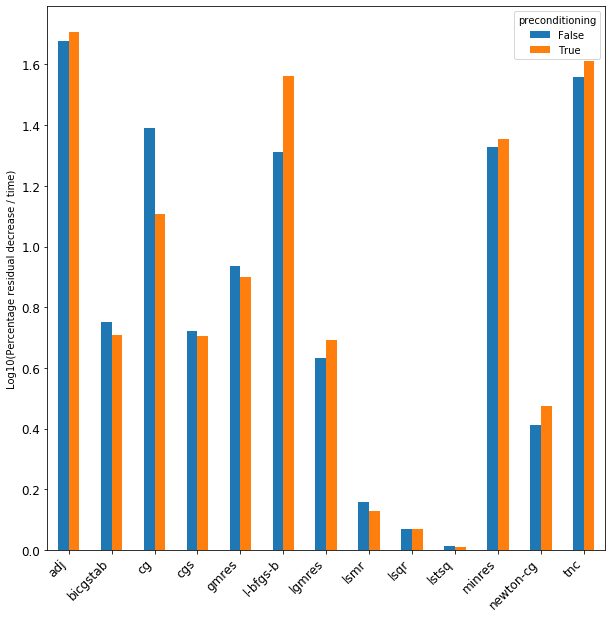

In [11]:
_ = method_scoring_df.groupby([method_scoring_df.index, method_scoring_df.preconditioning.astype(bool)]).sum().unstack().log10_efficiency.plot.bar(figsize=(10,10), fontsize=12)
loc, lab = plt.xticks()
_ = plt.xticks(loc, lab, ha='right', rotation=45)
plt.ylabel('Log10(Percentage residual decrease / time)')
plt.savefig('numerical_method_decrease_ratio_efficiency.jpg')